### Move Image Into One Folder:

In [1]:
!pip install opencv-python


Import Library

In [1]:
import os
import cv2
import numpy as np
import pathlib
import shutil
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import loguniform
from sklearn import preprocessing
from sklearn.decomposition import PCA

Crop Function Below

In [2]:
def augment_image(image):
    # Randomly rotate the image
    angle = np.random.randint(-20, 20)
    rows, cols, _ = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv2.warpAffine(image, rotation_matrix, (cols, rows))

    # Randomly shift the image horizontally and vertically
    max_shift = 0.1
    dx = np.random.uniform(-max_shift * cols, max_shift * cols)
    dy = np.random.uniform(-max_shift * rows, max_shift * rows)
    translation_matrix = np.float32([[1, 0, dx], [0, 1, dy]])
    image = cv2.warpAffine(image, translation_matrix, (cols, rows))

    # Randomly zoom the image
    zoom_range = (0.9, 1.1)
    zoom_factor = np.random.uniform(*zoom_range)
    center = (cols / 2, rows / 2)
    zoom_matrix = cv2.getRotationMatrix2D(center, 0, zoom_factor)
    image = cv2.warpAffine(image, zoom_matrix, (cols, rows))

    # Randomly flip the image horizontally
    if np.random.random() < 0.5:
        image = cv2.flip(image, 1)

    return image

In [3]:
def preprocess_and_augment_image(face_classifier:cv2.CascadeClassifier,image, target_size=(250,250), x=100, y=100, crop_width=800, crop_height=800):
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100))

    if len(faces) > 0:
        for i, (x, y, w, h) in enumerate(faces):
            img = img[y:y + h, x:x + w]
            img = cv2.resize(img, target_size,interpolation=cv2.INTER_CUBIC)


    else:
        print(f"No face detected in {image}. Performing a normal crop.")
        img = img[y:y + crop_height, x:x + crop_width]
        img = cv2.resize(img, target_size,interpolation=cv2.INTER_CUBIC)


    return img

Extract Image Into One Directory and Crop:

In [4]:
def moveImg(source_folder, target_folder):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)  # Create the target directory if it doesn't exist

    for person in os.listdir(source_folder):
        person_folder = os.path.join(source_folder, person)
        if os.path.isdir(person_folder):
            image_count = len([filename for filename in os.listdir(person_folder) if filename.endswith('.jpg')])
            if image_count >= 20:
                # Check if the person's folder already exists in the target directory
                person_target_folder = os.path.join(target_folder, person)
                if not os.path.exists(person_target_folder):
                    shutil.copytree(person_folder, person_target_folder)
                else:
                    print(f"Folder '{person}' already exists in the target directory.")

In [7]:
lfw_path = pathlib.Path('lfw_funneled')

new_path = pathlib.Path('extract_lfw')
if os.path.exists(lfw_path) and os.path.isdir(lfw_path):
    print(f"'{lfw_path}' directory exists.")
else:
    print(f"'{lfw_path}' directory does not exist.")
 
if not os.path.exists(new_path):
    os.mkdir(new_path)

moveImg(lfw_path,new_path)

'lfw_funneled' directory exists.


Clean Data: 

In [8]:
folder_path = 'extract_lfw'

    
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_frontalface_default.xml")

# Process images within subfolders
for person in os.listdir(folder_path):
    person_folder = os.path.join(folder_path, person)
    if os.path.isdir(person_folder):
        for filename in os.listdir(person_folder):
            if filename.endswith('.jpg'):
                image_path = os.path.join(person_folder, filename)
                preprocessed_image = preprocess_and_augment_image(face_classifier, image_path)
                cv2.imwrite(image_path, (preprocessed_image).astype(np.uint8))

No face detected in extract_lfw/Tom_Daschle/Tom_Daschle_0021.jpg. Performing a normal crop.
No face detected in extract_lfw/Gerhard_Schroeder/Gerhard_Schroeder_0100.jpg. Performing a normal crop.
No face detected in extract_lfw/Carlos_Menem/Carlos_Menem_0003.jpg. Performing a normal crop.
No face detected in extract_lfw/Jean_Chretien/Jean_Chretien_0037.jpg. Performing a normal crop.
No face detected in extract_lfw/Andre_Agassi/Andre_Agassi_0013.jpg. Performing a normal crop.
No face detected in extract_lfw/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0036.jpg. Performing a normal crop.
No face detected in extract_lfw/Colin_Powell/Colin_Powell_0185.jpg. Performing a normal crop.
No face detected in extract_lfw/Ricardo_Lagos/Ricardo_Lagos_0005.jpg. Performing a normal crop.
No face detected in extract_lfw/Lindsay_Davenport/Lindsay_Davenport_0015.jpg. Performing a normal crop.
No face detected in extract_lfw/Hans_Blix/Hans_Blix_0024.jpg. Performing a normal crop.
No face detected in extrac

Image Visualization:

In [9]:
folder_path = 'extract_lfw'
df_images = []
labels = []  # List to store image labels
for label, person in enumerate(os.listdir(folder_path)):
    if os.path.isdir(os.path.join(folder_path, person)):
        image_files = [filename for filename in os.listdir(os.path.join(folder_path, person)) if filename.endswith('.jpg')]
        
        # Check if there are images in the subfolder
        if image_files:
            for filename in image_files:
                img_path = os.path.join(folder_path, person, filename)
                img = cv2.imread(img_path)
                df_images.append(img)
                labels.append(label)  # Assigning label based on folder/class
        else:
            print(f"Skipping '{person}' due to no images in the subfolder.")
df_images = np.array(df_images)
labels = np.array(labels)


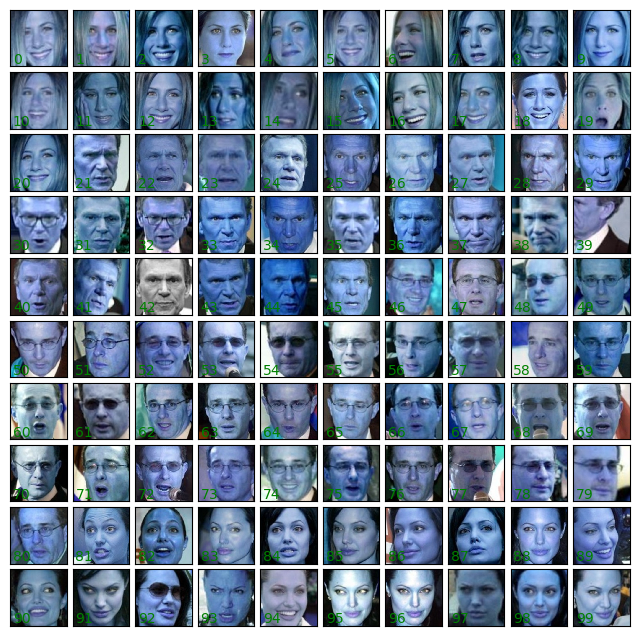

In [10]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks': [], 'yticks': []},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    if i < len(df_images):  # Ensure that the index is within the bounds of df_images
        ax.imshow(df_images[i], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
        ax.text(0.05, 0.05, str(i),
                transform=ax.transAxes, color='green')

plt.show()

Folder visualization: 

In [11]:

class_mapping = {}
class_images = {}

# Path to the directory containing subdirectories (classes)
directory_path = "extract_lfw"

for index, directory in enumerate(os.listdir(directory_path)):
        class_mapping[index] = directory  # Mapping the index to the directory name
        class_images[index] = len(os.listdir(os.path.join(directory_path, directory)))
        # Count the number of images in "Alejandro_Toledo" directory and store it

print("Class Mapping:", class_mapping)



Class Mapping: {0: 'Jennifer_Aniston', 1: 'Tom_Daschle', 2: 'Alvaro_Uribe', 3: 'Angelina_Jolie', 4: 'Mahmoud_Abbas', 5: 'Igor_Ivanov', 6: 'Jiang_Zemin', 7: 'John_Negroponte', 8: 'Jacques_Chirac', 9: 'Rudolph_Giuliani', 10: 'Gerhard_Schroeder', 11: 'Jose_Maria_Aznar', 12: 'Roh_Moo-hyun', 13: 'Hamid_Karzai', 14: 'Vladimir_Putin', 15: 'Jennifer_Lopez', 16: 'Tony_Blair', 17: 'Jack_Straw', 18: 'Pete_Sampras', 19: 'Amelie_Mauresmo', 20: 'Bill_Clinton', 21: 'Nestor_Kirchner', 22: 'Naomi_Watts', 23: 'Kofi_Annan', 24: 'Luiz_Inacio_Lula_da_Silva', 25: 'Paul_Bremer', 26: 'Carlos_Menem', 27: 'Winona_Ryder', 28: 'Tom_Ridge', 29: 'Jean_Chretien', 30: 'Andre_Agassi', 31: 'David_Beckham', 32: 'Donald_Rumsfeld', 33: 'Laura_Bush', 34: 'Arnold_Schwarzenegger', 35: 'Juan_Carlos_Ferrero', 36: 'Colin_Powell', 37: 'Saddam_Hussein', 38: 'Ricardo_Lagos', 39: 'Jeremy_Greenstock', 40: 'Lindsay_Davenport', 41: 'Hugo_Chavez', 42: 'Jennifer_Capriati', 43: 'Tiger_Woods', 44: 'Junichiro_Koizumi', 45: 'Gloria_Macapaga

In [12]:
total_num_images = np.sum(list(class_images.values()))
print("Individual \t Composition of Dataset\n")
for label, num_images in class_images.items():
 print("{:20} {:.2f}%".format(
 class_mapping[label], (num_images / total_num_images) * 100))

Individual 	 Composition of Dataset

Jennifer_Aniston     0.69%
Tom_Daschle          0.83%
Alvaro_Uribe         1.16%
Angelina_Jolie       0.66%
Mahmoud_Abbas        0.96%
Igor_Ivanov          0.66%
Jiang_Zemin          0.66%
John_Negroponte      1.03%
Jacques_Chirac       1.72%
Rudolph_Giuliani     0.86%
Gerhard_Schroeder    3.61%
Jose_Maria_Aznar     0.76%
Roh_Moo-hyun         1.06%
Hamid_Karzai         0.73%
Vladimir_Putin       1.62%
Jennifer_Lopez       0.69%
Tony_Blair           4.76%
Jack_Straw           0.93%
Pete_Sampras         0.73%
Amelie_Mauresmo      0.69%
Bill_Clinton         0.96%
Nestor_Kirchner      1.22%
Naomi_Watts          0.73%
Kofi_Annan           1.06%
Luiz_Inacio_Lula_da_Silva 1.59%
Paul_Bremer          0.66%
Carlos_Menem         0.69%
Winona_Ryder         0.79%
Tom_Ridge            1.09%
Jean_Chretien        1.82%
Andre_Agassi         1.19%
David_Beckham        1.03%
Donald_Rumsfeld      4.00%
Laura_Bush           1.36%
Arnold_Schwarzenegger 1.39%
Juan_Carlos_

In [13]:
!pip install opencv-python numpy matplotlib scikit-learn imbalanced-learn keras 
!pip install tensorflow

In [19]:
pip install --upgrade scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install --upgrade scikit-learn imbalanced-learn

  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/a3/9e/fbe60a768502af54563dcb59ca7856f5a8833b3ad5ada658922e1ab09b7f/imbalanced_learn-0.11.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 1.5 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install imbalanced-learn==0.7.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.11.0
    Uninstalling imbalanced-learn-0.11.0:
      Successfully uninstalled imbalanced-learn-0.11.0
Note: you may need to restart the kernel to use updated packages.


In [22]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.stats import loguniform
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


In [23]:
folder_path = 'extract_lfw'
df_images = []
labels = []  # List to store image labels
for label, person in enumerate(os.listdir(folder_path)):
    if os.path.isdir(os.path.join(folder_path, person)):
        image_files = [filename for filename in os.listdir(os.path.join(folder_path, person)) if filename.endswith('.jpg')]
        
        # Check if there are images in the subfolder
        if image_files:
            for filename in image_files:
                img_path = os.path.join(folder_path, person, filename)
                img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
                img = cv2.normalize(img, None, 0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                img = img.flatten()
                df_images.append(img)
                labels.append(label)  # Assigning label based on folder/class
        else:
            print(f"Skipping '{person}' due to no images in the subfolder.")
df_images = np.array(df_images)
labels = np.array(labels)


In [24]:
from sklearn.utils import shuffle

# Assuming 'X' is your data and 'y' is the corresponding labels
df_images, labels = shuffle(df_images, labels , random_state=42)

In [25]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_images, labels, test_size=0.3, random_state=42)

# Setting df_images and labels to 0 to deallocate memory
df_images = 0
labels = 0

# Printing the shapes of the training and testing sets
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(2116, 62500) (2116,)
(907, 62500) (907,)


In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [27]:
# Apply SMOTE to the training data
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(X_resampled.shape)
print(y_resampled.shape)

(23312, 62500)
(23312,)


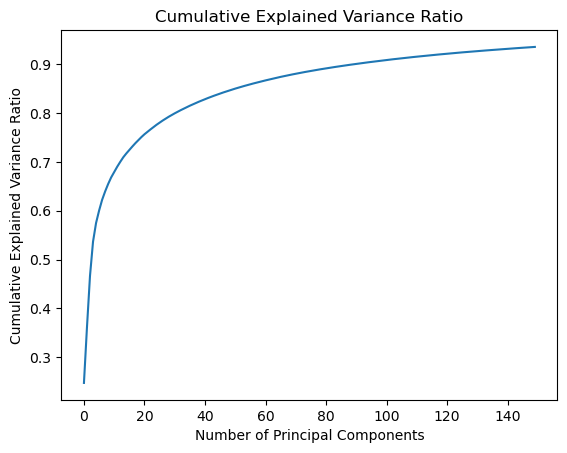

X_train_pca shape: (23312, 150)
X_test_pca shape: (907, 150)


In [31]:
# Assuming df_images, X_train, and X_test are defined previously

# Apply PCA to the scaled training data
pca = PCA(n_components=150,svd_solver="arpack",whiten=True)
X_train_pca = pca.fit_transform(X_resampled)

# Apply the same transformation to the testing data
X_test_pca = pca.transform(X_test)



# Plot explained variance ratio
cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_var_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.show()

# Print the shape of transformed data after PCA
print("X_train_pca shape:", X_train_pca.shape)
print("X_test_pca shape:", X_test_pca.shape)

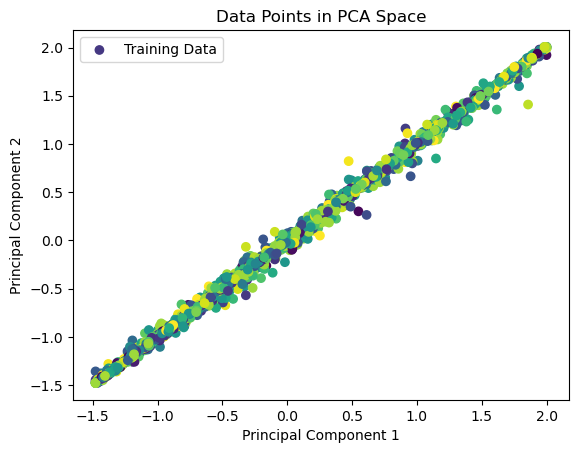

In [32]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', label='Training Data')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data Points in PCA Space')
plt.legend()
plt.show()

In [33]:

Svm = SVC(C= 1.4872681066575715, gamma= 0.003293320249656128, kernel= "rbf", class_weight="balanced")
Svm.fit(X_train_pca, y_resampled)


y_pred =Svm.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.59


In [ ]:
param_grid = {
    "C": loguniform(1e-1, 1e3),  # Adjusted range for 'C'
    "gamma": loguniform(1e-5, 1e-1),  # Adjusted range for 'gamma'
    'kernel': ['rbf', 'poly', 'sigmoid','linear']
}

# Use a scoring metric, such as accuracy
clf = RandomizedSearchCV(
    SVC(class_weight="balanced"), param_grid, cv=10, scoring='accuracy', n_iter=100
)

clf.fit(X_train_pca, y_resampled)
best_params = clf.best_params_
print("Best Parameters:", best_params)

y_pred = clf.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
